In [1]:
import gymnasium as gym

import numpy as np
import matplotlib.pylab as plot

from model_free_control import *

In [2]:
from math import ceil 

def windowed_avg(xs, window_size):
    avg_size = ceil(xs.shape[0] / window_size)
    avgs = np.empty(avg_size, dtype=xs.dtype)
    timesteps = np.empty(avg_size, dtype=np.int64)

    for i in range(avg_size):
        avgs[i] = xs[i * window_size: (i+1) * window_size].mean()
        timesteps[i] = i * window_size
    return timesteps, avgs

In [3]:
environment = gym.make("Blackjack-v1")

In [4]:
n_episodes = 100_000

n_observations=discrete_flatten_dim(environment.observation_space)
n_actions=discrete_flatten_dim(environment.action_space)
gamma=0.9
alpha_schedule=ExponentialSchedule(0.2, 4 / n_episodes)
epsilon_schedule=LinearSchedule(1.0, 0.01, n_episodes // 2)

agent_kwargs = {
    'n_observations': n_observations,
    'n_actions': n_actions,
    'gamma': gamma,
    'alpha_schedule': alpha_schedule,
    'epsilon_schedule': epsilon_schedule
}

agents = {
    'sarsa': SarsaAgent(**agent_kwargs),
    'q_learning': QLearningAgent(**agent_kwargs),
    'double_q_learning': DoubleQLearningAgent(**agent_kwargs),
    'expected_sarsa': ExpectedSarsa(**agent_kwargs),
}

In [5]:
reward_histories = {}

for name, agent in agents.items():
    print(f"{name}:")
    reward_history, n_terminated, n_truncated = train(environment, agent, n_episodes)
    reward_histories[name] = reward_history

    print(f"#terminated: {n_terminated}, #truncated: {n_truncated}, terminated ratio {n_terminated / max(1, n_terminated + n_truncated):.2%}")
    print()

sarsa:


100%|██████████| 100000/100000 [00:15<00:00, 6297.76it/s]


#terminated: 100000, #truncated: 0, terminated ratio 100.00%

q_learning:


100%|██████████| 100000/100000 [00:16<00:00, 6147.29it/s]


#terminated: 100000, #truncated: 0, terminated ratio 100.00%

double_q_learning:


100%|██████████| 100000/100000 [00:16<00:00, 6092.73it/s]


#terminated: 100000, #truncated: 0, terminated ratio 100.00%

expected_sarsa:


100%|██████████| 100000/100000 [00:16<00:00, 6026.93it/s]

#terminated: 100000, #truncated: 0, terminated ratio 100.00%



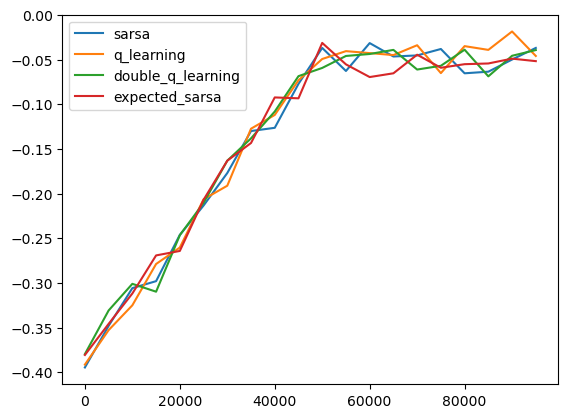

In [6]:
for name, reward_history in reward_histories.items():
    x, y = windowed_avg(reward_history, n_episodes // 20)
    plot.plot(x, y, label=name)
plot.legend()

In [7]:
for name, agent in agents.items():
    reward_mean, reward_std, n_terminated, n_truncated = evaluate(environment, agent, 1_000, progress_bar=False)
    print(name)
    print(f"mean reward: {reward_mean:.2f} (± {reward_std:.2f})")
    print(f"#terminated: {n_terminated}, #truncated: {n_truncated}, terminated ratio {n_terminated / max(1, n_terminated + n_truncated):.2%}")
    print()

sarsa
mean reward: -0.03 (± 0.96)
#terminated: 1000, #truncated: 0, terminated ratio 100.00%

q_learning
mean reward: -0.09 (± 0.94)
#terminated: 1000, #truncated: 0, terminated ratio 100.00%

double_q_learning
mean reward: -0.04 (± 0.95)
#terminated: 1000, #truncated: 0, terminated ratio 100.00%

expected_sarsa
mean reward: -0.01 (± 0.94)
#terminated: 1000, #truncated: 0, terminated ratio 100.00%



In [8]:
def plot_action_value_blackjack(q: np.array, usable_ace: bool):
    from matplotlib.colors import ListedColormap

    def set_labels(axis):
        x_labels = ['A'] + [str(i) for i in range(2, 11)]
        axis.set_xticks(range(len(x_labels)), x_labels)

        y_labels = range(12, 22)
        axis.set_yticks(range(len(y_labels)), y_labels)

        axis.set_xlabel("Player sum")
        axis.set_ylabel("Dealer showing")

    value_stick = q[:,0].reshape(32, 11, 2)[12:22, 1:11, int(usable_ace)]
    value_hit = q[:,1].reshape(32, 11, 2)[12:22, 1:11, int(usable_ace)]

    value_max_policy = np.maximum(value_stick, value_hit)

    fig, axes = plot.subplots(1, 2, figsize=plot.figaspect(0.4))
    fig.suptitle("usable ace" if usable_ace else "no usable ace")

    axes[0].matshow(value_max_policy)
    set_labels(axes[0])

    cmap = ListedColormap(["gray", "lightgreen"])
    axes[1].matshow(value_hit > value_stick, cmap=cmap)
    set_labels(axes[1])

    for i, s in enumerate(value_hit > value_stick):
        for j, a in enumerate(s):
            axes[1].text(j, i, int(a), ha="center", va="center")

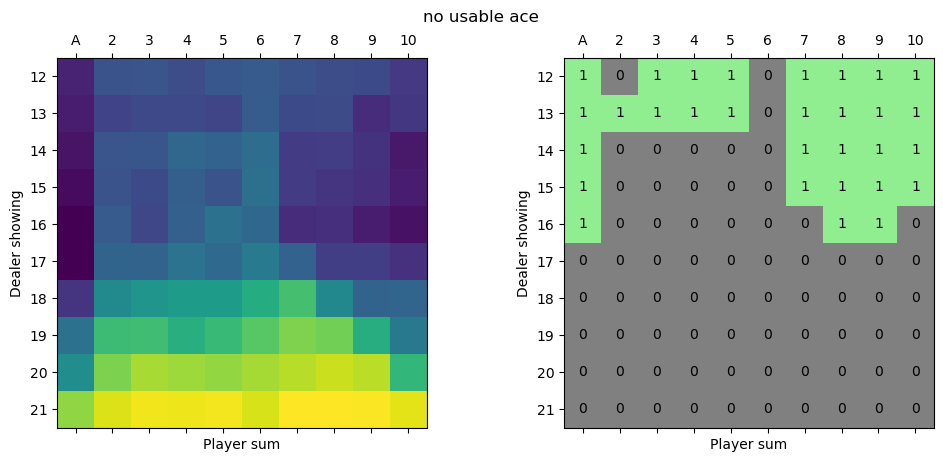

In [9]:
plot_action_value_blackjack(agents['sarsa'].q, False)

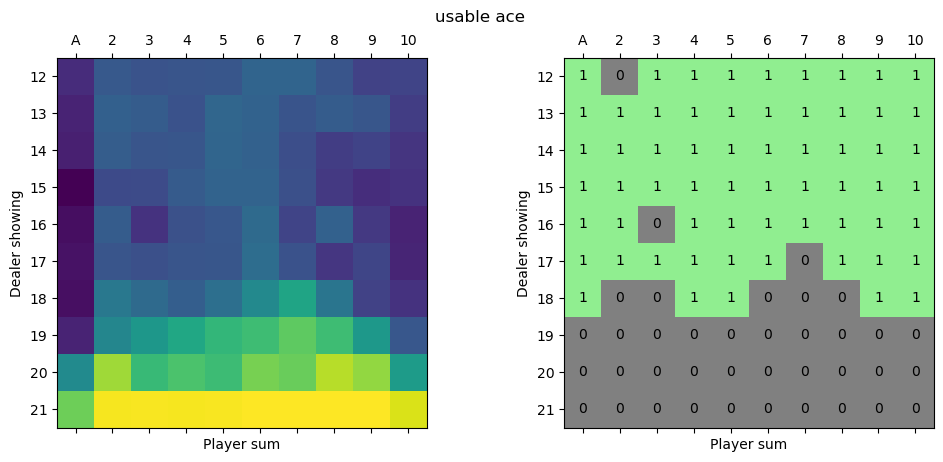

In [10]:
plot_action_value_blackjack(agents['sarsa'].q, True)

In [11]:
environment = gym.make("CliffWalking-v0")
environment = gym.wrappers.TimeLimit(environment, 100)

In [12]:
n_episodes = 20_000

n_observations=discrete_flatten_dim(environment.observation_space)
n_actions=discrete_flatten_dim(environment.action_space)
gamma=0.9
alpha_schedule=ExponentialSchedule(0.2, 4 / n_episodes)
epsilon_schedule=LinearSchedule(1.0, 0.1, n_episodes)

agent_kwargs = {
    'n_observations': n_observations,
    'n_actions': n_actions,
    'gamma': gamma,
    'alpha_schedule': alpha_schedule,
    'epsilon_schedule': epsilon_schedule
}

agents = {
    'sarsa': SarsaAgent(**agent_kwargs),
    'q_learning': QLearningAgent(**agent_kwargs),
    'double_q_learning': DoubleQLearningAgent(**agent_kwargs),
    'expected_sarsa': ExpectedSarsa(**agent_kwargs),
}

In [13]:
reward_histories = {}

for name, agent in agents.items():
    print(f"{name}:")
    reward_history, n_terminated, n_truncated = train(environment, agent, n_episodes)
    reward_histories[name] = reward_history

    print(f"#terminated: {n_terminated}, #truncated: {n_truncated}, terminated ratio {n_terminated / max(1, n_terminated + n_truncated):.2%}")
    print()

sarsa:


100%|██████████| 20000/20000 [00:50<00:00, 398.70it/s]


#terminated: 171, #truncated: 19829, terminated ratio 0.85%

q_learning:


100%|██████████| 20000/20000 [00:32<00:00, 610.07it/s] 


#terminated: 14062, #truncated: 5938, terminated ratio 70.31%

double_q_learning:


100%|██████████| 20000/20000 [00:33<00:00, 597.47it/s] 


#terminated: 13305, #truncated: 6695, terminated ratio 66.53%

expected_sarsa:


100%|██████████| 20000/20000 [01:13<00:00, 272.67it/s]

#terminated: 88, #truncated: 19912, terminated ratio 0.44%



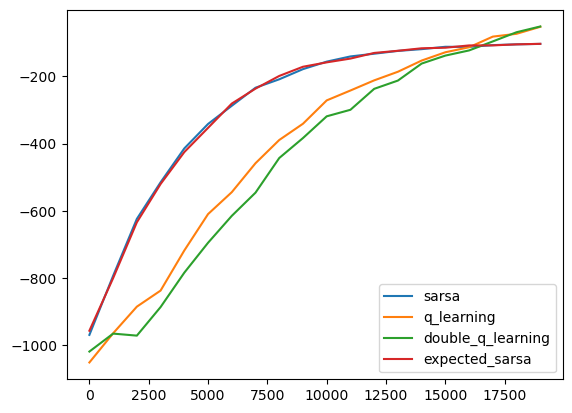

In [14]:
for name, reward_history in reward_histories.items():
    x, y = windowed_avg(reward_history, n_episodes // 20)
    plot.plot(x, y, label=name)
plot.legend()

In [15]:
for name, agent in agents.items():
    reward_mean, reward_std, n_terminated, n_truncated = evaluate(environment, agent, 1_000, progress_bar=False)
    print(name)
    print(f"mean reward: {reward_mean:.2f} (± {reward_std:.2f})")
    print(f"#terminated: {n_terminated}, #truncated: {n_truncated}, terminated ratio {n_terminated / max(1, n_terminated + n_truncated):.2%}")
    print()

sarsa
mean reward: -102.38 (± 15.79)
#terminated: 0, #truncated: 1000, terminated ratio 0.00%

q_learning
mean reward: -48.92 (± 66.84)
#terminated: 1000, #truncated: 0, terminated ratio 100.00%

double_q_learning
mean reward: -47.09 (± 67.18)
#terminated: 1000, #truncated: 0, terminated ratio 100.00%

expected_sarsa
mean reward: -103.17 (± 18.51)
#terminated: 0, #truncated: 1000, terminated ratio 0.00%



In [16]:
environment = gym.make("CliffWalking-v0", render_mode="human")
environment = gym.wrappers.TimeLimit(environment, 100)

agent = agents['q_learning']

observation, info = environment.reset(seed=42)
for _ in range(100):
   action = agent.get_action(discrete_flatten(environment.observation_space, observation), eval=True)
   action = discrete_unflatten(environment.action_space, action)

   observation, reward, terminated, truncated, info = environment.step(action)

   if terminated or truncated:
      observation, info = environment.reset()

environment.close()

import pygame
pygame.quit()